# Modelling and simulating COVID-19 using agent based models

<p class="pm-node nj-authors">Marc Sturrock, RCSI [marcsturrock@rcsi.com]</p>

Here we expand upon the simple ODE based SIR model in the previous notebook to consider agent based models. We make use of the julia package "Agents.jl" for this. Note that these models are also stochastic, so repeated runs will yield different results. In general with stochastic models, we rely on summary statistics like mean and variance to judge the model behaviour. 

Here is what will be covered in this session:

- [x] Agent based models description 
- [x] SIR model
- [x] Model parameters
- [x] Making the model in Agents.jl
- [x] Example animation
- [x] Delta vs Omicron

# Model Description: Agent Based Model (ABM)

An agent-based (or individual-based) model is a computational simulation of autonomous agents that react to their environment (including other agents) given a predefined set of rules. ABMs have been adopted and studied in a variety of research disciplines. One reason for their popularity is that they enable a relaxation of many simplifying assumptions usually made by mathematical models and thus have greater flexibility.

Agent-based models are increasingly recognised as a useful approach for studying complex systems. Complex systems cannot be fully understood using traditional mathematical tools which aggregate the behaviour of elements in a system. The behavior of a complex system depends on both the behavior of and interactions between its elements (agents). Small changes in the input to complex systems or the behaviour of its agents can lead to large changes in outcome. That is to say, a complex system's behaviour is nonlinear, and that it is not only the sum of the behaviour of its elements. Use of ABMs have become feasible after the availability of computers and has been growing ever since, especially in modelling biological and economical systems, and has extended to social studies and archaeology.

An ABM consists of autonomous agents that behave given a set of rules. A classic example of an ABM is Schelling's segregation model which uses a regular grid and defines agents at random positions on the grid. Agents can be from different social groups. Agents are happy/unhappy based on the fraction of their neighbours that belong to the same group as they are. If they are unhappy, they keep moving to new locations until they are happy. Schelling's model shows that even small preferences of agents to have neighbours belonging to the same group (e.g. preferring that at least 30% of neighbours to be in the same group) could lead to total segregation of neighbourhoods. This is an example of emergent behaviour from simple interactions of agents that can only be captured in an agent-based model.

# SIR model

A SIR model tracks the ratio of Susceptible, Infected, and Recovered individuals within a population. Here we add one more category of individuals: those who are infected, but do not know it. Transmission rate for infected and diagnosed individuals is lower than infected and undetected. We also allow a fraction of recovered individuals to catch the disease again, meaning that recovering the disease does not bring full immunity.

# Model parameters

Here are the model parameters, some of which have default values.

- Ns: a vector of population sizes per city. The amount of cities is just C=length(Ns).
- β_und: a vector for transmission probabilities β of the infected but undetected per city. Transmission probability is how many susceptible are infected per day by an infected individual. If social - distancing is practiced, this number decreases.
- β_det: an array for transmission probabilities β of the infected and detected per city. If hospitals are full, this number increases.
- infection_period = 30: how many days before a person dies or recovers.
- detection_time = 14: how many days before an infected person is detected.
- death_rate = 0.02: the probability that the individual will die after the infection_period.
- reinfection_probability = 0.05: The probability that a recovered person can get infected again.
- migration_rates: A matrix of migration probability per individual per day from one city to another.
- Is = [zeros(C-1)..., 1]: An array for initial number of infected but undetected people per city. This starts as only one infected individual in the last city.

Notice that Ns, β, Is all need to have the same length, as they are numbers for each city. We've tried to add values to the infection parameters similar to the ones you would hear on the news about COVID-19.

The good thing with Agent based models is that you could easily extend the model we implement here to also include age as an additional property of each agent. This makes ABMs flexible and suitable for research of virus spreading.

# Making the model in Agents.jl

We start by defining the Person agent type and the ABM

In [16]:
using Agents, Random, DataFrames, Graphs
using Distributions: Poisson, DiscreteNonParametric
using DrWatson: @dict
using CairoMakie

mutable struct Person <: AbstractAgent
    id::Int #A unique number associated with each individual
    pos::Int #Current position of individual
    location::Int #original location or home location
    days_infected::Int  # number of days since is infected
    status::Symbol  # 1: S, 2: I, 3:R
end

function model_initiation(;
    Ns,
    migration_rates,
    β_und,
    β_det,
    infection_period = 30,
    reinfection_probability = 0.05,
    detection_time = 14,
    death_rate = 0.02,
    Is = [zeros(Int, length(Ns) - 1)..., 1],
    seed = 0,
)

    rng = MersenneTwister(seed)
    @assert length(Ns) ==
    length(Is) ==
    length(β_und) ==
    length(β_det) ==
    size(migration_rates, 1) "length of Ns, Is, and B, and number of rows/columns in migration_rates should be the same "
    @assert size(migration_rates, 1) == size(migration_rates, 2) "migration_rates rates should be a square matrix"

    C = length(Ns)
    # normalize migration_rates
    migration_rates_sum = sum(migration_rates, dims = 2)
    for c in 1:C
        migration_rates[c, :] ./= migration_rates_sum[c]
    end

    properties = @dict(
        Ns,
        Is,
        β_und,
        β_det,
        β_det,
        migration_rates,
        infection_period,
        infection_period,
        reinfection_probability,
        detection_time,
        C,
        death_rate
    )
    space = Agents.GraphSpace(Graphs.SimpleGraphs.barabasi_albert(C,1,1))
    model = ABM(Person, space; properties, rng)

    # Add initial individuals
    for household in 1:C, n in 1:Ns[household]
        if rand() > 0.0
            ind = add_agent!(household, model,household, 0, :S) # Susceptible
        else
            ind = add_agent!(household, model,household, 0, :R) # Susceptible
        end
    end
    # add infected individuals
    for household in 1:C
        inds = ids_in_position(household, model)
        for n in 1:Is[household]
            agent = model[inds[n]]
            agent.status = :I # Infected
            agent.days_infected = 1
        end
    end
    return model
end

model_initiation (generic function with 1 method)

We will make a function that starts a model with C number of households, and creates the other parameters automatically by attributing some random values to them. You could directly use the above constructor and specify all Ns, β, etc. for a given set of households.

Households are connected to each other using a Barabasi-Albert graph which is a good model of social interactions.

In [17]:
using LinearAlgebra: diagind

function create_params(;
    C,
    max_travel_rate,
    infection_period = 30,
    reinfection_probability = 0.1,
    detection_time = 14,
    death_rate = 0.01,
    #Is = [zeros(Int, C - 1)..., 1], #Is = rand([0,0,1],C)
    Is = rand([0,0,1],C),
    seed = 19,
)

    Random.seed!(seed)
    Ns = rand(1:10, C)
    β_und = 1 .* rand(0.3:0.02:0.6, C)
    β_det = 1 .* β_und ./ 10

    Random.seed!(seed)
    migration_rates = zeros(C, C)
    for c in 1:C
        for c2 in 1:C
            migration_rates[c, c2] = (Ns[c] + Ns[c2]) / Ns[c]
        end
    end
    maxM = maximum(migration_rates)
    migration_rates = (migration_rates .* max_travel_rate) ./ maxM
    migration_rates[diagind(migration_rates)] .= 1.0

    params = @dict(
        Ns,
        β_und,
        β_det,
        migration_rates,
        infection_period,
        reinfection_probability,
        detection_time,
        death_rate,
        Is
    )

    return params
end

params = create_params(C = 100, max_travel_rate = 0.01,reinfection_probability = 0.005,death_rate = 0.02)
model = model_initiation(; params...)

function agent_step!(agent, model)
    migrate!(agent, model)
    transmit!(agent, model)
    update!(agent, model)
    recover_or_die!(agent, model)
end

function migrate!(agent, model)
    current_location = agent.pos
    home = agent.location
    d = DiscreteNonParametric(1:(model.C), model.migration_rates[current_location, :])
    m = rand(model.rng, d)
    if current_location ≠ home
        move_agent!(agent, home, model)
    elseif m ≠ current_location && m ∈ nearby_positions(current_location,model)
        move_agent!(agent, m, model)
    end
end

function transmit!(agent, model)
    agent.status == :S && return
    rate = if agent.days_infected < model.detection_time
        model.β_und[agent.pos]
    else
        model.β_det[agent.pos]
    end

    d = Poisson(rate)
    n = rand(model.rng, d)
    n == 0 && return

    for contactID in ids_in_position(agent, model)
        contact = model[contactID]
        if contact.status == :S || (contact.status == :R && rand(model.rng) ≤ model.reinfection_probability)
            contact.status = :I
            n -= 1
            n == 0 && return
        end
    end
end

update!(agent, model) = agent.status == :I && (agent.days_infected += 1)

function recover_or_die!(agent, model)
    if agent.days_infected ≥ model.infection_period
        if rand(model.rng) ≤ model.death_rate
            kill_agent!(agent, model)
        else
            agent.status = :R
            agent.days_infected = 0
        end
    end
end

recover_or_die! (generic function with 1 method)

# Example animation

In [18]:
using InteractiveDynamics
abmobs = ABMObservable(model; agent_step!)

alive_fractions(m) = [length(ids_in_position(p, m)) for p in positions(m)]
infected_fraction(m, x) = count(m[id].status == :I for id in x) / length(x)
infected_fractions(m) = [infected_fraction(m, ids_in_position(p, m)) for p in positions(m)]
alives = lift(alive_fractions,abmobs.model)
fracs = lift(infected_fractions, abmobs.model)
color = lift(fs -> [cgrad(:inferno)[f] for f in fs], fracs)
title = lift(
    (s, m) -> "step = $(s), infected = $(round(Int, 100infected_fraction(m, allids(m))))%",
    abmobs.s, abmobs.model
)
using Base64
using GraphMakie
fig = Figure(resolution = (1200, 800))
ax2 = Axis(fig[1, 1]; title, xlabel = "x", ylabel = "y")
graphplot!(ax2,model.space.graph,node_color=color,node_size=alives)
Colorbar(fig[1, 2],label = "percentage infected")
fig
record(fig, "covid_evolution.mp4"; framerate = 5) do io
    for j in 1:100
        recordframe!(io)
        Agents.step!(abmobs, 1)
    end
    recordframe!(io)
end
function showanim(filename)
    base64_video = base64encode(open(filename))
    display("text/html", """<video controls src="data:video/x-m4v;base64,$base64_video">""")
end
showanim("covid_evolution.mp4")

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAB7bhtZGF0AAACnwYF//+b3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJlYWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTMgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj01IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhlYWQ9NTAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMC4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAACUEmWIhAAU//731LfMsu1Tb7YLqPeiniZfQ3UlAZuWxO06gAAAAwAAAwAAAwAAAwMirpg2OTV/QdwkAAOobeyPb23RngAIurXBsXCTGQSt+ZY78RSalPeUWZscZfBXWPEXFKudCdZFXMBn4ozDeqR6e9M1lTPyFCa2A3miBTJzITK2zovrjoc8P/d9AmiI9tlk0EW3nNo7KpP5sDn89d1C9O24jliYeGGw1fQbb7T7U2BaBrm2J/bTpFD7QtrJePMyeV65fz2lNzrEzkm2j+fG1bI72y4OkvzkMBrfQS/KJ5J/DJkyUatkbI8BkRtJILTWBpgab7YJrlxuZSy1346hDOOs3g6SaZ/OgXUh1wkk17MBwITXCnqf7kMeo3+bJo7Q/PjvxcBksRAZ0KQ/uXRhM2zfsdGsTK/xC0HJcs6fWg57niYXI5fXALuOP9xHNKSJ9/nyITftMzoLx7OD/r6B/a9W9a3M3MpfpCWqAbQxUmbWz7sMNK0WELKKc8rrlRUNzUYOWbjoCtvLluLD2wosgLY26v5cSqFN2brUqHNPdd61srYoNdK3OKWbGauXxjPE1Bv81ZX9KpSrLL96in7CbzYR1f/Jp0UVsFEXGtWXrd2wKXfn5Api50rM+DsWj3SpU0T7Fq3Fn2icTkAac5gO6+7DdX2RKuybf7Ev1OFCY6UM5274/jExy3ZBo/2bxmZ4qjNSmDEL0J47iKOS9J8iWxU+uLPTIpN83wVzA7Mq4vW0tdERwjNkeeTXDGB1MlZaeDl9uYCQiLnxQVa9ldfVKWXhWMrTJBt/MCYqApmGmyqe7a+hB/deBp+LDyJtrTGF5rYjQ/Dva8pLhLAgQVeZWBMXljM1VfUIO6FE94uzBEwYVvLqxg3PgMLh39tqe0IGqQLVA3K/f8lcDz2fkvlNxmBzpYLhDG+KK7hwgU3dboFEbzbG2m99j4J6D26qZujkF2ENJOW6titZRisU2LQCxqkdegpsfcPHiiKcI2fdbISOMvYjkCOAb8wUCW4vt8pz8ZgiF2cYzPcWvMyuGGik0oEaeX4UFaUUnklp9EPzQ4tx063MjhM/Y8bWUFhfF5jkQoyP2jKF6ItADQztvj4JrQEcVrRTZouZkR21diqXQ6+0cwaozLSp8KoIM2mCsuz0cH++wji08Q7vKXBK5DLZIGyvmhVefs22dqEIrBiBSjVE+PhejBn5DJsSKr3AA7P8pOQ5KlCzUd1tyoigwDuXu/Mn/AbW583+er5dkhSJaNLRLl9M26qjlaL9yDxI8qdENbVXwduc9wBCRy7fZHmEwoVKujM7nGuqpn8eYX+G6Kw6YAbimKXbWiRK6Ow7UTQ0hRKxJJ+rOgN3npLQUBMI/Or1iVWFCn2I4ELvCqYZ1VP+iTzg5HEy24VMSoAKy1h9Pn0ezrHV2AtkoBHE7+KCgwgfvyCrEIDuv3Uw0v7xJZSpS45uozG5VamCmU733yh9vMmBR8A6PwjH1ROnV11R2ZdXIZKSyib1JcgegWJ5woc4TUVvnJ7afvm+SSulRhbosIaNwvQ57uyf2tifzZAj/r0IFG4vsjh6W5MNtnLnZoGB+WQGvrMBszr7ctjLh9fM3Izjzsvn7Vuq0LUqXTLQeb6GPE9arouxgVd4T63EANKVMMZOsLQEh6Wm0lkcEbPHLwzjqGK/0w/ps0q4viI8b+Q2ClsVByA8XamJeNctpHKSxRHq4cvllYCYMS/fKlIZ7tYLfQjTOAmEeCKhtXzK2NtC/HCJbzsdzr2uh0uvpT2et2jcRVKBbZoK04/XRO0brH8m4m0MJMqprn7Dy/kW2UJLRl/oy/9Es5YSI1QsjkFsK2xaTIySHyjUwy9RIs7BAQgFS3DfcoB4p7+P+pyY4ewVC2Pe+eMoB7Q7gzkKkDoV+W2ayvA3T9Ck1qhXHRdpUQYE4g66j2lUY8L+jEHAecdiSJDSfBfwxuvGhjT7unnXz4Ru6YMK8DVYMQn3hLbK044YNpLIMTBH/f6zGjUrD9k3Q7/fJ4CAHMgjWIV0GgADgyAwG+g7je1p85c9GyksK/2dmRALd/vhGuDOHYtbmebrXi6LML2iLxZ5zlX9peCYu4wOhOwpcXujS3T6GN+8HY4s+slxDGuaTOyg3WupcL2+qe6swh/rsfA64u3g54MCWg4cgke6dYdm2HBMHXp0BnGflvF1r/ijpOat21aeGVqG1iB5m1mVCJakhqhVLiYNlgjNmqe55G+eVjwKk15JhiS3v1MgnSGqGORH+X6YKy46VBI+NQwiU2xQ3ZaksbZNcnevZ531j0iRJQZnOcuqRwBd5fF566Y/73bN68Bd4v5UhE7wkLTp9mk+Rmvm2BUTFmYXSMtkHJiN/wOk+ORajWWSfXn5/NXMFfNCnhpLsEaMZ6WeoeE/VGf6GomCZRVJQjLMF/na1k4ho+rE3EK5yQzXy6t6NbV5b28DyKNfdQ4XwsGCTEplznQD6E/fdxbJNDTxyyd/56VMrJMm5R4yDECFHIpiprpOC3zeZo51QN1hRwkAZcu0vu3pQzsuSLZcK5r/tI78ddjiBSo3Pis4NNL40x3SeIE09zm2n3waglPOvFUx5Q70LJBJvDGfRmKwrvr6z65OeO/1vjuB39+Dw7L4AALqPUA8E2jhiMvAq0aVgWXrKQwAtMyB80KPnS4cLV0psMsAiSGzkf3THxaMNmOZa/BF2auHoHTnPqgJx+E3EplXNQhthUpS1qEbzHYHKOfrDa73vxocYY7Eiyq+YF59h22MpdlanTZyJeeGmQbREz9914jg5x+YeD3ojX9hg0mT6B/VQAADIQOgjOkqET1uIDyQDv1I3umPbJebN4uyDWgaI4tR8LYBzV3rMPMx7yJwO7R1c7+xkSxNXFgvIDidfibYsqb04yG+QMFORD5VSUEslhKH4om55LeHzpTirp9uZ5fNtVwoZYSyIKBESn9QYhzO3/FGuM2S0v7w5kt0AqxcnQdxASc1uRvHg5+

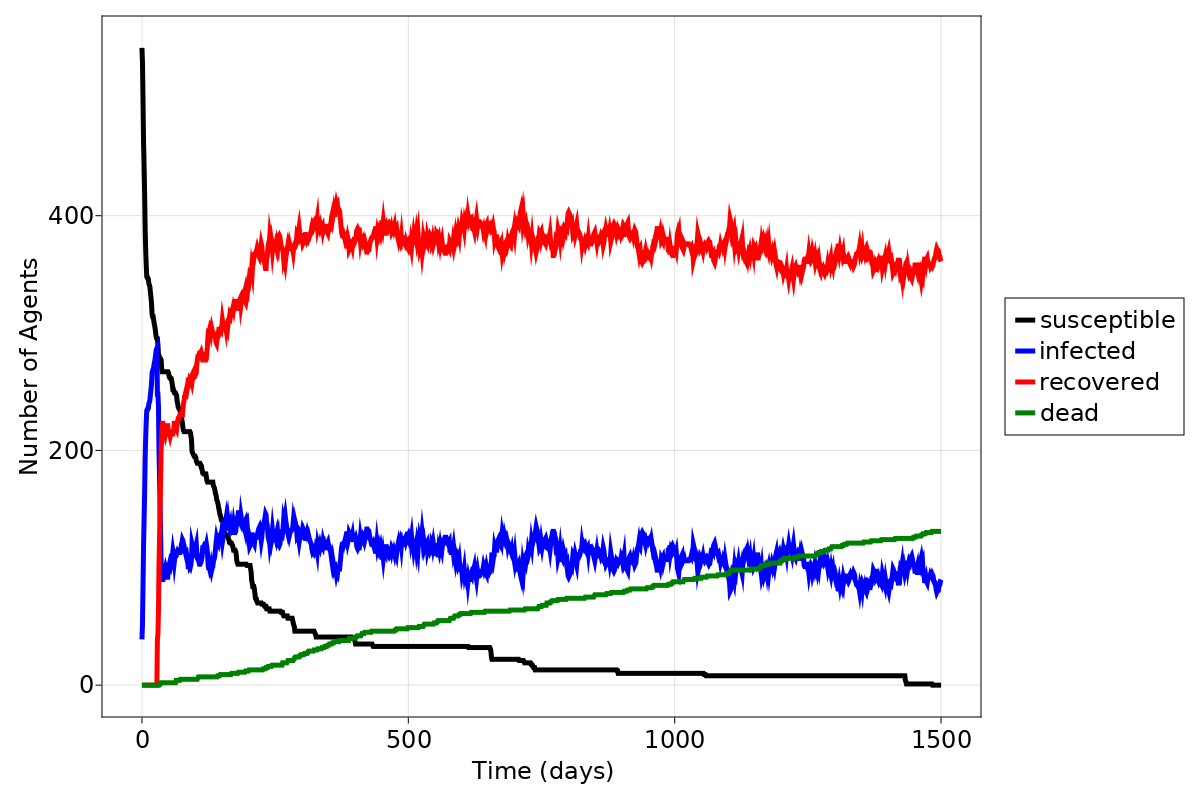

In [19]:
infected(x) = count(i == :I for i in x)
susceptible(x) = count(i == :S for i in x)
recovered(x) = count(i == :R for i in x)

model = model_initiation(; params...)

to_collect = [(:status, f) for f in (susceptible, infected, recovered, length)]
data, _ = run!(model, agent_step!, 1500; adata = to_collect)

N = sum(model.Ns) # Total initial population
x = data.step
fig = Figure(resolution = (1200, 800),fontsize=24,grid=false)
ax = fig[1, 1] = Axis(fig, xlabel = "Time (days)", ylabel = "Number of Agents", textsize = 24)
ls = lines!(ax, x, data[:, aggname(:status, susceptible)], color = :black,linewidth=5)
li = lines!(ax, x, data[:, aggname(:status, infected)], color = :blue,linewidth=5)
lr = lines!(ax, x, data[:, aggname(:status, recovered)], color = :red,linewidth=5)
dead = N .- data[:, aggname(:status, length)]
ld = lines!(ax, x, dead, color = :green,linewidth=5,grid=false)
fig[1, 2] = Legend(fig, [ls,li, lr, ld], ["susceptible","infected", "recovered", "dead"], textsize = 24)
fig

## Simulating Delta vs Omicron variants

Omicron is known to have a higher chance of reinfection than delta as well as a smaller death rate. Therefore to simulate a more omicron like variant try executing the above cells with the below lines changed

In [15]:
params = create_params(C = 100, max_travel_rate = 0.01,reinfection_probability = 0.05,death_rate = 0.002)
model = model_initiation(; params...)

AgentBasedModel with 582 agents of type Person
 space: GraphSpace with 100 positions and 99 edges
 scheduler: fastest
 properties: Is, death_rate, infection_period, β_und, Ns, migration_rates, detection_time, reinfection_probability, β_det, C